## NeuroPolis: Cascading Disaster Prediction Model

The Data Farmers\
Date: Apr 15, 2025

# Exploratory Data Analysis

🔍 Dataset Shape: (50000, 20)

📋 Data Types:
 event_id_disaster                     int64
latitude                            float64
longitude                           float64
disaster_type                        object
severity                              int64
casualties                            int64
economic_loss_million_usd           float64
duration_hours                        int64
timestamp                    datetime64[ns]
location_event                       object
type                                 object
business_id                           int64
revenue_usd                         float64
transactions                          int64
temperature_c                       float64
humidity_%                          float64
wind_speed_kmph                     float64
pressure_hpa                        float64
precipitation_mm                    float64
zone_id                             float64
dtype: object

🧼 Missing Values:
 event_id_disaster            0
latitude  

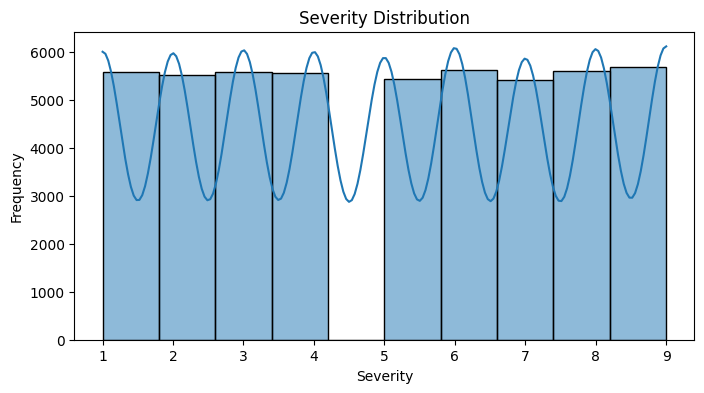

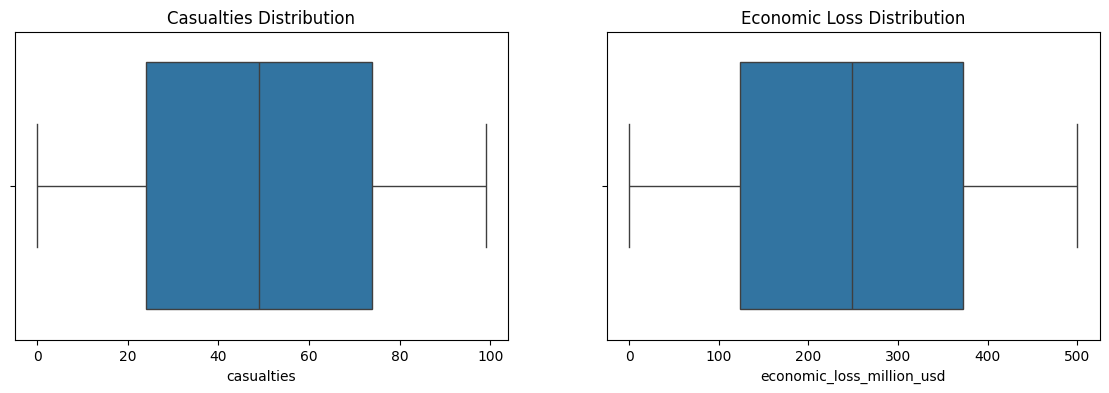

<ipython-input-3-a6d2e0d0d2ee>:48: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


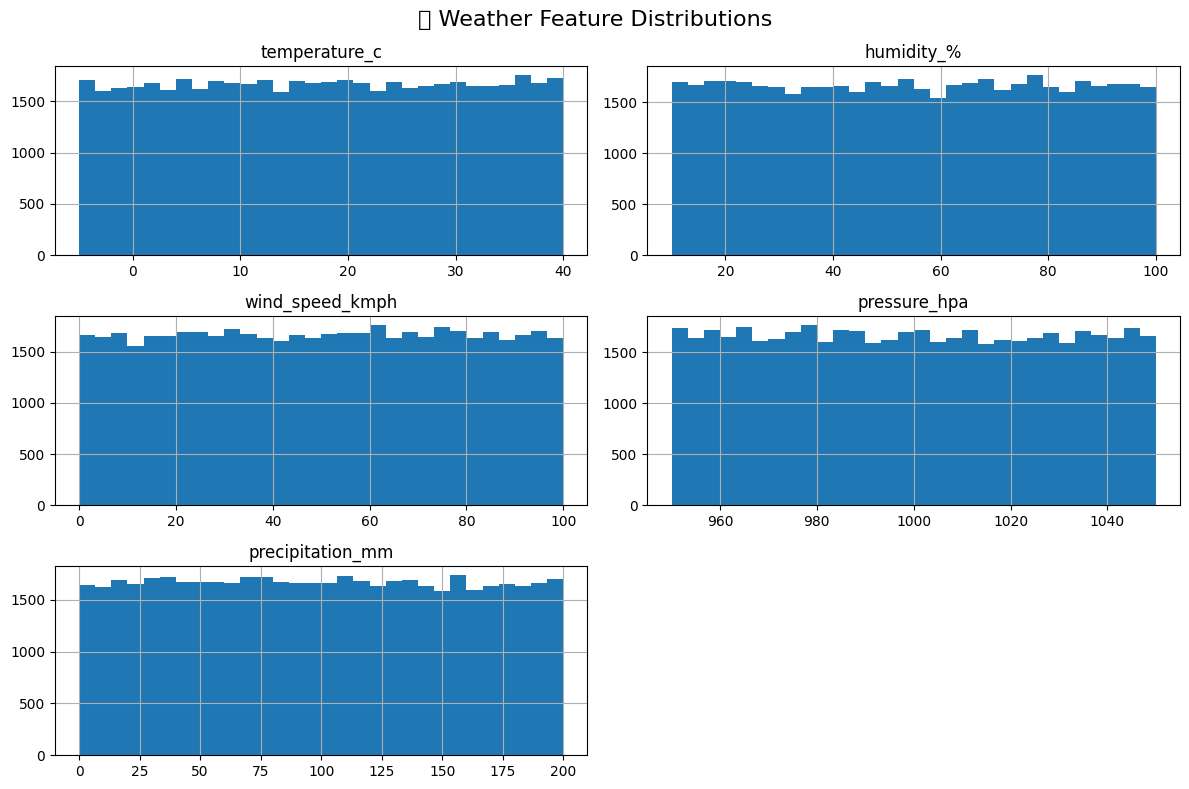

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


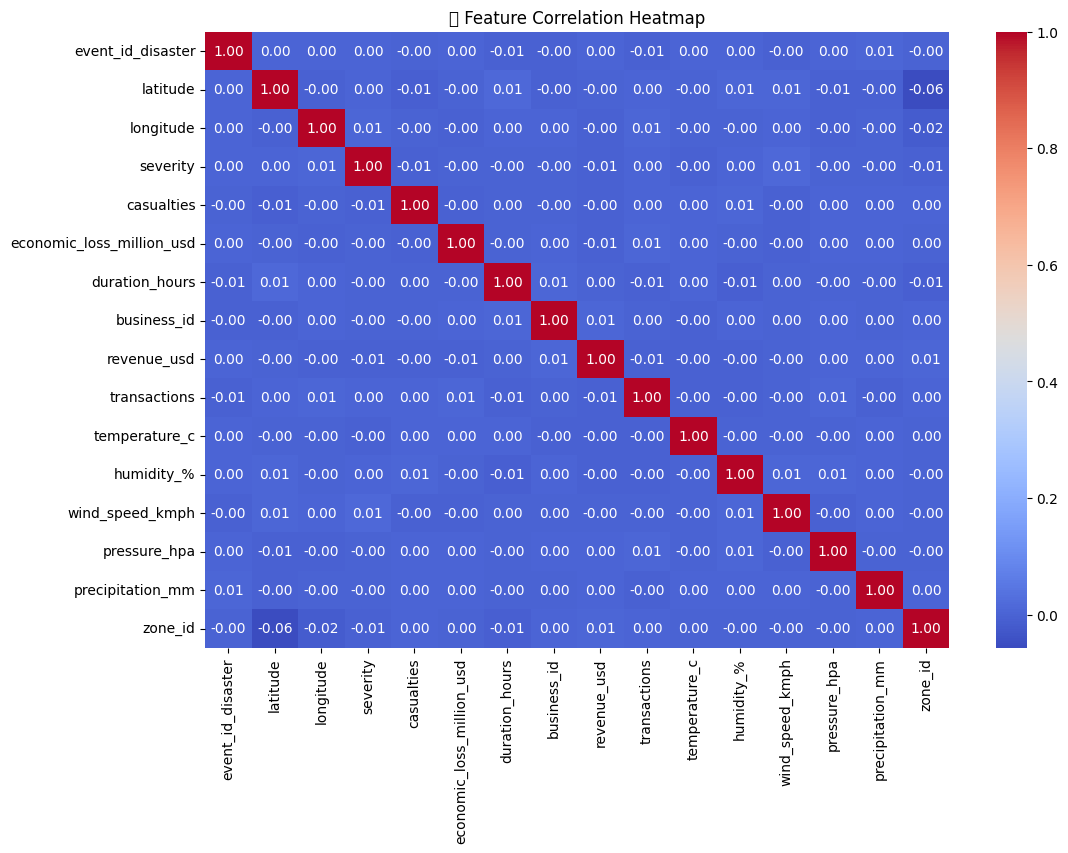

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


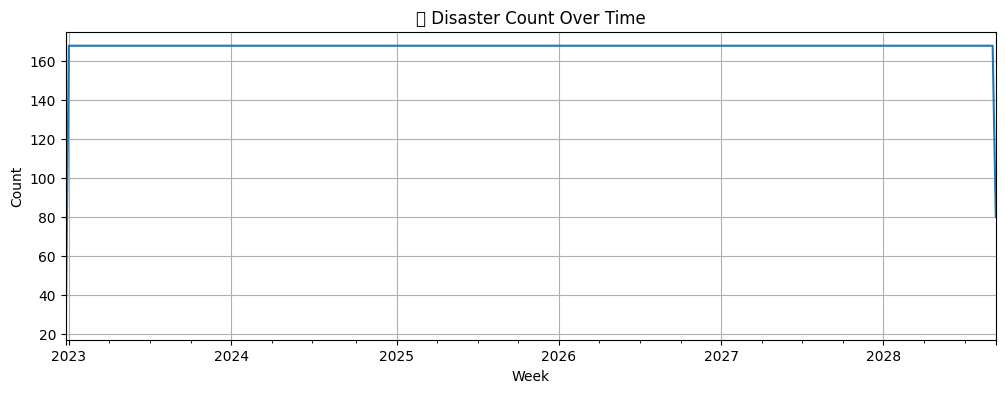

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("final_merged_with_zones.csv", parse_dates=["timestamp"])

# --- BASIC INFO ---
print("🔍 Dataset Shape:", df.shape)
print("\n📋 Data Types:\n", df.dtypes)
print("\n🧼 Missing Values:\n", df.isna().sum())

# --- BASIC STATS ---
print("\n📊 Descriptive Stats:\n", df.describe())

# --- TEMPORAL COVERAGE ---
print("\n🕒 Time Range:\n", df['timestamp'].min(), " → ", df['timestamp'].max())

# --- ZONE DISTRIBUTION ---
print("\n📍 Number of Unique Zones:", df['zone_id'].nunique())
print("📍 Top 5 Most Active Zones:\n", df['zone_id'].value_counts().head())

# --- DISASTER TYPE COUNTS ---
if "disaster_type" in df.columns:
    print("\n🌪️ Disaster Type Counts:\n", df["disaster_type"].value_counts())

# --- SEVERITY DISTRIBUTION ---
if "severity" in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df["severity"].dropna(), bins=10, kde=True)
    plt.title("Severity Distribution")
    plt.xlabel("Severity")
    plt.ylabel("Frequency")
    plt.show()

# --- CASUALTIES & ECONOMIC LOSS ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot(x=df["casualties"], ax=axes[0])
axes[0].set_title("Casualties Distribution")
sns.boxplot(x=df["economic_loss_million_usd"], ax=axes[1])
axes[1].set_title("Economic Loss Distribution")
plt.show()

# --- WEATHER SNAPSHOT ---
weather_cols = ["temperature_c", "humidity_%", "wind_speed_kmph", "pressure_hpa", "precipitation_mm"]
df[weather_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("🌦️ Weather Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# --- CORRELATION HEATMAP ---
plt.figure(figsize=(12,8))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("📈 Feature Correlation Heatmap")
plt.show()

# --- TIME SERIES EXAMPLE: Number of Disasters per Week ---
# Ensure 'timestamp' is datetime before using .dt accessor
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert to datetime if not already
df['week'] = df['timestamp'].dt.to_period('W').dt.start_time
df.groupby('week').size().plot(figsize=(12,4), title="🗓️ Disaster Count Over Time")
plt.xlabel("Week")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Data Prep + Model Building

In [4]:
print("🧾 Columns in the dataset:\n", df.columns.tolist())


🧾 Columns in the dataset:
 ['event_id_disaster', 'latitude', 'longitude', 'disaster_type', 'severity', 'casualties', 'economic_loss_million_usd', 'duration_hours', 'timestamp', 'location_event', 'type', 'business_id', 'revenue_usd', 'transactions', 'temperature_c', 'humidity_%', 'wind_speed_kmph', 'pressure_hpa', 'precipitation_mm', 'zone_id', 'week']


In [5]:
# 🔁 Define cascading disaster conditions based on extreme weather and impact
df["is_cascading_disaster"] = (
    (
        (df["wind_speed_kmph"] > 75) |        # 🚩 High wind speed
        (df["precipitation_mm"] > 150)        # 🚩 Intense rainfall
    ) &
    (df["severity"] >= 4.5) &                   # 🔥 Moderate-to-severe disaster
    (df["casualties"] > 10)                   # ⚠️ Significant human impact
).astype(int)

# 📊 Display the proportion of cascading disasters
print("🔍 Cascading disaster label distribution:")
print(df["is_cascading_disaster"].value_counts(normalize=True))


🔍 Cascading disaster label distribution:
is_cascading_disaster
0    0.78396
1    0.21604
Name: proportion, dtype: float64


In [7]:
# Add the 'risk_level' column and initialize it with a default value (e.g., 'unknown')
df['risk_level'] = 'unknown'

# Low risk
df.loc[
    ((df["wind_speed_kmph"].between(25, 75)) | (df["precipitation_mm"].between(50, 150))) &
    (df["severity"] >= 3.0) &
    (df["casualties"] <= 10) &
    (df["risk_level"] != "critical"),
    "risk_level"
] = "low"

# Safe zone
df.loc[
    (df["wind_speed_kmph"] < 25) &
    (df["precipitation_mm"] < 50) &
    (df["severity"] <= 3.0) &
    (df["casualties"] <= 5),
    "risk_level"
] = "safe"


# 3-Model Training & Evaluation (RF + XGB + LGBM)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 🎯 Define target and clean input features
target = "is_cascading_disaster"
# Include 'week' in drop_cols since it's a datetime feature and not suitable for scaling
drop_cols = ["event_id_disaster", "timestamp", "zone_id", target, 'week']
X = df.drop(columns=drop_cols)
y = df[target]

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/val/test (64/16/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# ----------------- MODEL 1: Random Forest -----------------
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

print("\n🌲 Random Forest:")
print(classification_report(y_val, rf_preds))

# ----------------- MODEL 2: XGBoost -----------------
xgb = XGBClassifier(n_estimators=100, max_depth=5, scale_pos_weight=3, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)

print("\n⚡ XGBoost:")
print(classification_report(y_val, xgb_preds))

# ----------------- MODEL 3: LightGBM -----------------
lgb = LGBMClassifier(n_estimators=100, max_depth=5, scale_pos_weight=3, learning_rate=0.1, random_state=42)
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_val)

print("\n💡 LightGBM:")
print(classification_report(y_val, lgb_preds))


🌲 Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6272
           1       1.00      1.00      1.00      1728

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:53:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



⚡ XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6272
           1       1.00      1.00      1.00      1728

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

[LightGBM] [Info] Number of positive: 6914, number of negative: 25086


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216062 -> initscore=-1.288762
[LightGBM] [Info] Start training from score -1.288762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


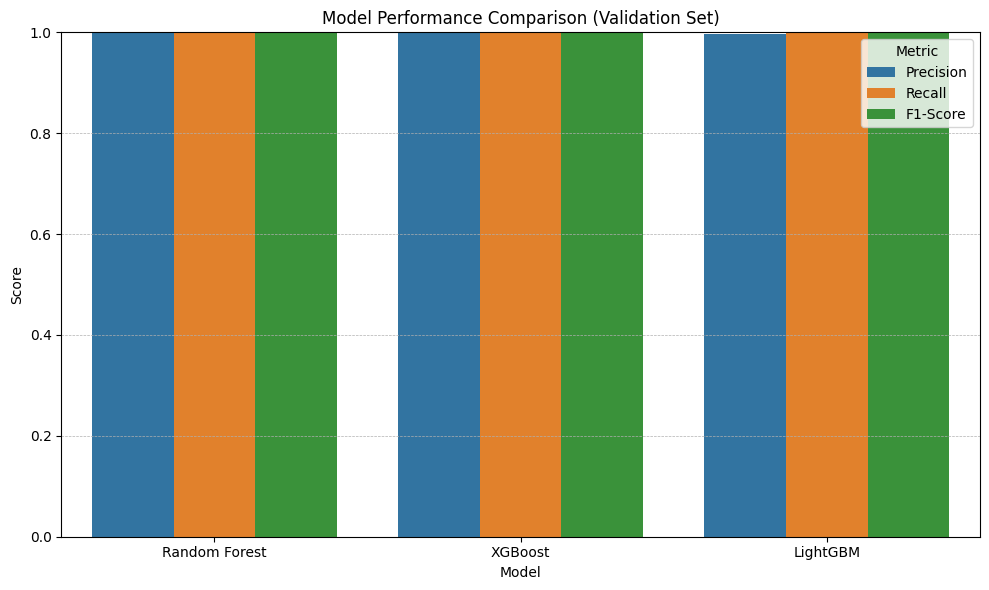

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Collect metrics for each model
models = {
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LightGBM": lgb_preds
}

metrics_dict = {"Model": [], "Metric": [], "Score": []}
for name, preds in models.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average="binary", zero_division=0)
    metrics_dict["Model"].extend([name]*3)
    metrics_dict["Metric"].extend(["Precision", "Recall", "F1-Score"])
    metrics_dict["Score"].extend([precision, recall, f1])

# Create a DataFrame for plotting
metrics_df = pd.DataFrame(metrics_dict)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison (Validation Set)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.legend(title="Metric")
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_temp = RandomForestClassifier()
rf_temp.fit(X_train, y_train)

importances = pd.Series(rf_temp.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(10))


severity                     0.356333
wind_speed_kmph              0.252981
precipitation_mm             0.251243
casualties                   0.059232
risk_level_unknown           0.017728
latitude                     0.006104
pressure_hpa                 0.006052
revenue_usd                  0.005998
economic_loss_million_usd    0.005971
temperature_c                0.005955
dtype: float64


<ipython-input-12-3ac00f06d2ef>:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


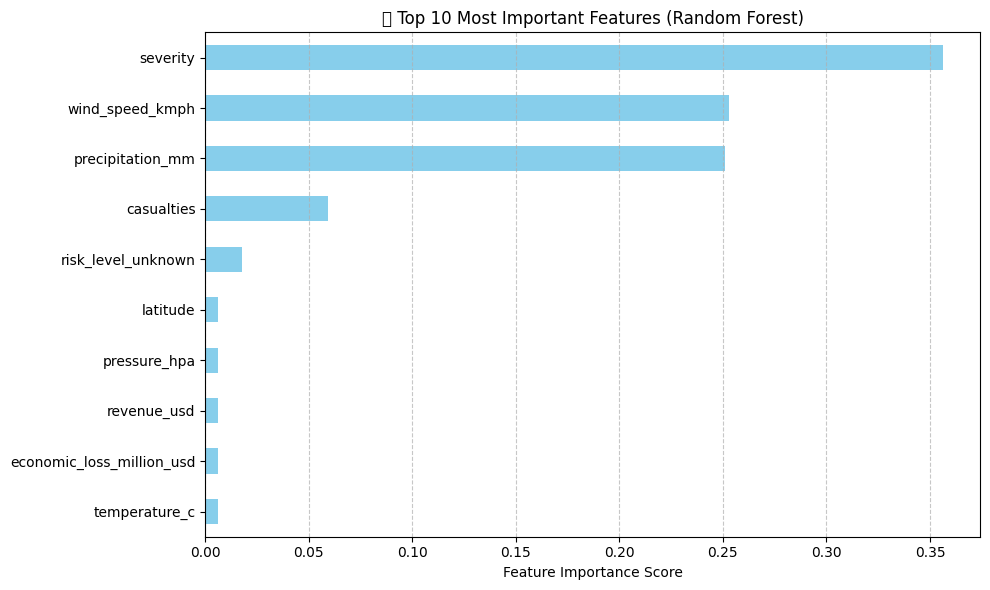

In [12]:
import matplotlib.pyplot as plt

# Sort and get top 10
top_importances = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
top_importances.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()  # Highest on top
plt.xlabel("Feature Importance Score")
plt.title("🔍 Top 10 Most Important Features (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
